In [1]:
import logging
import multiprocessing
import warnings
from itertools import repeat
from pathlib import Path

import astropy.units as u
from astropy.time import Time
import click
import matplotlib.pyplot as plt
import numpy as np
from astropy.coordinates import SkyCoord, Angle
from astropy.table import Table
from regions import CircleSkyRegion
from scipy.stats import norm

from gammapy.data import GTI, EventList, Observation, Observations
from gammapy.datasets import MapDataset, MapDatasetEventSampler, Datasets, SpectrumDataset, FluxPointsDataset
from gammapy.estimators import ExcessMapEstimator, LightCurveEstimator
from gammapy.irf import EnergyDispersion2D, load_cta_irfs
from gammapy.makers import MapDatasetMaker, FoVBackgroundMaker, SpectrumDatasetMaker, ReflectedRegionsBackgroundMaker
from gammapy.maps import Map, MapAxis, WcsGeom, RegionGeom
from gammapy.modeling import Fit
from gammapy.modeling.models import Models, FoVBackgroundModel
from gammapy.utils.table import table_from_row_data

In [2]:
import gammapy
gammapy.__version__

'0.20.1'

In [64]:
from gammapy.modeling.models import (
    Model,
    Models,
    SkyModel,
    PowerLawSpectralModel,
    PointSpatialModel,
    DiskSpatialModel,
    GaussianSpatialModel,
    TemplateSpatialModel,
    ExpCutoffPowerLawSpectralModel,
    LogParabolaSpectralModel,
    PowerLaw2SpectralModel,
    ExpCutoffPowerLaw3FGLSpectralModel,
    SuperExpCutoffPowerLaw4FGLSpectralModel,
    PowerLawNormSpectralModel,
    FoVBackgroundModel,
    TemplateSpectralModel,
    ExpDecayTemporalModel,
    GaussianTemporalModel,
    LightCurveTemplateTemporalModel,
)

In [4]:
BASE_PATH = Path("make.py").parent

AVAILABLE_MODELS = [
    "point-pwl",
    "point-ecpl",
    "point-log-parabola",
    "point-pwl2",
    "point-ecpl-3fgl",
    "point-ecpl-4fgl",
    "point-template",
    "diffuse-cube",
    "disk-pwl",
    "gauss-pwl",
    "point-pwl-expdecay",
]

DPI = 120

# observation config
IRF_FILE = ("$GAMMAPY_DATA/cta-caldb/"+
            "Prod5-South-20deg-AverageAz-14MSTs37SSTs.180000s-v0.1.fits.gz")

POINTING = SkyCoord(0.0, 0.5, frame="galactic", unit="deg")
LIVETIME = 1 * u.hr
GTI_TABLE = GTI.create(start=0 * u.s, stop=LIVETIME.to(u.s))

# dataset config
ENERGY_AXIS = MapAxis.from_energy_bounds("0.1 TeV", "100 TeV", 
                                         nbin=10, per_decade=True)
ENERGY_AXIS_TRUE = MapAxis.from_energy_bounds(
    "0.03 TeV", "300 TeV", nbin=20, per_decade=True, name="energy_true"
)
MIGRA_AXIS = MapAxis.from_bounds(0.5, 2, nbin=150, 
                                 node_type="edges", name="migra")

WCS_GEOM = WcsGeom.create(
    skydir=POINTING, width=(2, 2), binsz=0.02, 
    frame="galactic", axes=[ENERGY_AXIS]
)

In [5]:
irfs = load_cta_irfs(IRF_FILE)
observation = Observation.create(
    obs_id=1001, pointing=POINTING, livetime=LIVETIME, irfs=irfs
)

empty = MapDataset.create(
    WCS_GEOM, energy_axis_true=ENERGY_AXIS_TRUE, migra_axis=MIGRA_AXIS
)
maker = MapDatasetMaker(selection=["exposure", "background", 
                                   "psf", "edisp"])
dataset = maker.run(empty, observation)

filename_dataset = ("/Users/fabiopintore/LAVORO/Gammapy/"+
              "gammapy-benchmarks/validation/event-sampling/"
              +"data/dataset_1h.fits.gz")
dataset.write(filename_dataset, overwrite=True)

In [6]:
#dataset = MapDataset.read(filename_dataset)

filename_events = ("/Users/fabiopintore/LAVORO/Gammapy/"
                  + "gammapy-benchmarks/validation/" +
                    "event-sampling/data/models/point-pwl/" + 
                    "events_1h_0000.fits.gz")
events = EventList.read(filename_events)

counts = Map.from_geom(WCS_GEOM)
counts.fill_events(events)
dataset.counts = counts

<WCSAxesSubplot:xlabel='Galactic Longitude', ylabel='Galactic Latitude'>

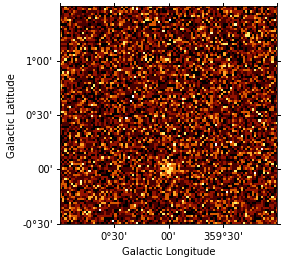

In [7]:
counts.reduce_over_axes().plot()

In [33]:
filename_model = ("/Users/fabiopintore/LAVORO/Gammapy/"
                 +"gammapy-benchmarks/validation/event-sampling/"
                 +"models/point-pwl.yaml")
models = Models.read(filename_model)

models.append(FoVBackgroundModel(dataset_name=dataset.name))

dataset.models = models

In [35]:
dataset.models[0].name

'point-pwl'

In [9]:
spatial_model = PointSpatialModel(lon_0="20.0 deg",
                          lat_0="11.0 deg",
                          frame="galactic")

spectral_model = PowerLawSpectralModel(
                index=2.0,
                amplitude="1e-12 TeV-1 cm-2 s-1",
                reference="1 TeV"
                )

sky_model = SkyModel(spectral_model = spectral_model,
             spatial_model = spatial_model,
             name="test_source")

models = Models([sky_model, FoVBackgroundModel(dataset_name=dataset.name)])

In [10]:
dataset.models = models
print(dataset.models)

DatasetModels

Component 0: SkyModel

  Name                      : test_source
  Datasets names            : None
  Spectral model type       : PowerLawSpectralModel
  Spatial  model type       : PointSpatialModel
  Temporal model type       : 
  Parameters:
    index                         :      2.000   +/-    0.00             
    amplitude                     :   1.00e-12   +/- 0.0e+00 1 / (cm2 s TeV)
    reference             (frozen):      1.000       TeV         
    lon_0                         :     20.000   +/-    0.00 deg         
    lat_0                         :     11.000   +/-    0.00 deg         

Component 1: FoVBackgroundModel

  Name                      : imVKP5HW-bkg
  Datasets names            : ['imVKP5HW']
  Spectral model type       : PowerLawNormSpectralModel
  Parameters:
    norm                          :      1.000   +/-    0.00             
    tilt                  (frozen):      0.000                   
    reference             (frozen):      1.00

In [11]:
#dataset.fake()

In [12]:
fit = Fit()
result = fit.run(dataset)

Position <SkyCoord (Galactic): (l, b) in deg
    (20., 11.)> is outside valid IRF map range, using nearest IRF defined within


In [15]:
models[0].spectral_model.plot?

Signature:
spectral_model.plot(
    energy_bounds,
    ax=None,
    sed_type='dnde',
    energy_power=0,
    n_points=100,
    **kwargs,
)
Docstring:
Plot spectral model curve.

kwargs are forwarded to `matplotlib.pyplot.plot`

By default a log-log scaling of the axes is used, if you want to change
the y axis scaling to linear you can use::

    from gammapy.modeling.models import ExpCutoffPowerLawSpectralModel
    from astropy import units as u

    pwl = ExpCutoffPowerLawSpectralModel()
    ax = pwl.plot(energy_bounds=(0.1, 100) * u.TeV)
    ax.set_yscale('linear')

Parameters
----------
ax : `~matplotlib.axes.Axes`, optional
    Axis
energy_bounds : `~astropy.units.Quantity`
    Plot energy bounds passed to MapAxis.from_energy_bounds
sed_type : {"dnde", "flux", "eflux", "e2dnde"}
    Evaluation methods of the model
energy_power : int, optional
    Power of energy to multiply flux axis with
n_points : int, optional
    Number of evaluation nodes
**kwargs : dict
    Keyword arguments 

In [4]:
POINTING = SkyCoord(70.0, 0.5, frame="galactic", unit="deg")
LIVETIME = 10 * u.hr

IRF_FILE = ("$GAMMAPY_DATA/cta-caldb/"+
            "Prod5-South-20deg-AverageAz-14MSTs37SSTs.180000s-v0.1.fits.gz")
irfs = load_cta_irfs(IRF_FILE)

In [5]:
# Define map geometry for binned simulation
energy_reco = MapAxis.from_bounds(0.5, 200, nbin=20, unit="TeV", name="energy", interp="log")
geom = WcsGeom.create(
    skydir=POINTING,
    binsz=0.02,
    width=(3, 3),
    frame="galactic",
    axes=[energy_reco],
)
# It is usually useful to have a separate binning for the true energy axis
energy_true = MapAxis.from_bounds(0.1, 300, nbin=30, unit="TeV", name="energy_true", interp="log")

empty = MapDataset.create(
    geom, name="dataset-simu", energy_axis_true=energy_true
)

In [6]:
obs = Observation.create(
    pointing=POINTING, livetime=LIVETIME, irfs=irfs,
)

In [7]:
maker = MapDatasetMaker(selection=["exposure", "background", "psf", "edisp"])
dataset = maker.run(empty, obs)

In [8]:
spatial_model = PointSpatialModel(lon_0="70.0 deg",
                          lat_0="1.0 deg",
                          frame="galactic")

spectral_model = PowerLawSpectralModel(
                index=2.0,
                amplitude="1e-12 TeV-1 cm-2 s-1",
                reference="1 TeV"
                )

sky_model = SkyModel(spectral_model = spectral_model,
             spatial_model = spatial_model,
             name="test_source")

models = Models([sky_model, FoVBackgroundModel(dataset_name=dataset.name)])

In [9]:
dataset.models = models
dataset.fake()

In [10]:
print(dataset)

MapDataset
----------

  Name                            : dataset-simu 

  Total counts                    : 22691 
  Total background counts         : 22130.77
  Total excess counts             : 560.23

  Predicted counts                : 22798.67
  Predicted background counts     : 22130.77
  Predicted excess counts         : 667.89

  Exposure min                    : 6.35e+09 m2 s
  Exposure max                    : 1.37e+11 m2 s

  Number of total bins            : 450000 
  Number of fit bins              : 450000 

  Fit statistic type              : cash
  Fit statistic value (-2 log(L)) : 128737.87

  Number of models                : 2 
  Number of parameters            : 8
  Number of free parameters       : 5

  Component 0: SkyModel
  
    Name                      : test_source
    Datasets names            : None
    Spectral model type       : PowerLawSpectralModel
    Spatial  model type       : PointSpatialModel
    Temporal model type       : 
    Parameters:
     

<WCSAxesSubplot:xlabel='Galactic Longitude', ylabel='Galactic Latitude'>

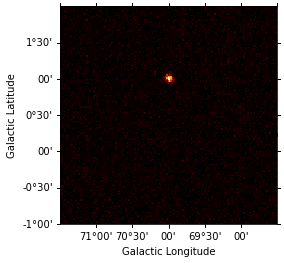

In [11]:
dataset.counts.sum_over_axes().plot()

In [12]:
fit = Fit(optimize_opts={"print_level": 1})
result = fit.run(datasets=[dataset])

Position <SkyCoord (Galactic): (l, b) in deg
    (71.75196279, 1.)> is outside valid IRF map range, using nearest IRF defined within
Position <SkyCoord (Galactic): (l, b) in deg
    (71.75196279, 1.)> is outside valid IRF map range, using nearest IRF defined within
Position <SkyCoord (Galactic): (l, b) in deg
    (68.24803721, 1.)> is outside valid IRF map range, using nearest IRF defined within
Position <SkyCoord (Galactic): (l, b) in deg
    (68.24803721, 1.)> is outside valid IRF map range, using nearest IRF defined within


In [9]:
filename = f"data/dataset_{LIVETIME.value:.0f}{LIVETIME.unit}.fits.gz"
file = BASE_PATH / filename

In [26]:
a=Path(str(file).replace("dataset","observation"))
Observation.read?

Signature: Observation.read(event_file, irf_file=None)
Docstring:
Create an Observation from a Event List and an (optional) IRF file.

Parameters
----------
event_file : str, Path
    path to the .fits file containing the event list and the GTI
irf_file : str, Path
    (optional) path to the .fits file containing the IRF components,
    if not provided the IRF will be read from the event file

Returns
-------
observation : `~gammapy.data.Observation`
    observation with the events and the irf read from the file
File:      ~/opt/anaconda3/envs/gammapy-0.20.1/lib/python3.8/site-packages/gammapy/data/observations.py
Type:      method


# LC

In [5]:
irfs = load_cta_irfs(IRF_FILE)

t0 = Time(51544.00074287037, format="mjd", scale="tt")

observation = Observation.create(
   obs_id=1001, pointing=POINTING, livetime=LIVETIME, irfs=irfs, tstart=t0
)

In [6]:
filename_dataset = ("/Users/fabiopintore/LAVORO/Gammapy/gammapy-benchmarks/"+
                    "validation/event-sampling/data/dataset_1h.fits.gz")
filename_events = ("/Users/fabiopintore/LAVORO/Gammapy/gammapy-benchmarks/"+
                    "validation/event-sampling/data/models/point-pwl-gausstemp/events_1h_0000.fits.gz")

# from gammapy.data import DataStore
# data_store = DataStore.from_events_files([filename_events])
# data_store.obs_table.rename_column('TSTART', 'START')
# data_store.obs_table.rename_column('TSTOP', 'STOP')

# obs_ids=0
# observations = data_store.get_observations([obs_ids])

In [7]:
dataset = MapDataset.read(filename_dataset)
events = EventList.read(filename_events)
counts = Map.from_geom(WCS_GEOM)
counts.fill_events(events)
dataset.counts = counts
observation._events = events

In [235]:
# data_store.obs_table.meta['MJDREFF'] = 0.000742870368412695

In [236]:
# data_store.obs_table

In [8]:
t0 = Time(51544.00074287037, format="mjd", scale="tt")
duration = 3 * u.min
n_time_bins = 20
times = t0 + np.arange(n_time_bins) * duration
time_intervals = [
    Time([tstart, tstop]) for tstart, tstop in zip(times[:-1], times[1:])
]

In [9]:
observations = Observations([observation])
short_observations = observations.select_time(time_intervals)

In [10]:
datasets = Datasets()

target = SkyCoord(0.0, 0.0, frame="galactic", unit="deg")
on_region_radius = Angle("0.11 deg")
on_region = CircleSkyRegion(center=target, radius=on_region_radius)

geom = RegionGeom.create(region=on_region, axes=[ENERGY_AXIS])
stacked = SpectrumDataset.create(geom, energy_axis_true=ENERGY_AXIS_TRUE)

# stacked = MapDataset.create(
#     WCS_GEOM, energy_axis_true=ENERGY_AXIS_TRUE, migra_axis=MIGRA_AXIS
# )
# maker = MapDatasetMaker(selection=["counts", "exposure", "edisp"])
maker = SpectrumDatasetMaker(
    containment_correction=True, selection=["counts", "exposure", "edisp"]
 )
# bkg_maker = ReflectedRegionsBackgroundMaker()

#circle = CircleSkyRegion(center=POINTING, radius=0.2 * u.deg)
#exclusion_mask = WCS_GEOM.region_mask([circle], inside=False)

#fov_bkg_maker = FoVBackgroundMaker(method="fit", exclusion_mask=exclusion_mask)
# bkg_maker = FoVBackgroundMaker()
bkg_maker = ReflectedRegionsBackgroundMaker()

#dataset_new = maker.run(stacked, observation)
#dataset_new = fov_bkg_maker.run(dataset_new)
#stacked.stack(dataset_new)

#dataset_new = maker.run(stacked, observation)
#dataset_new = fov_bkg_maker.run(dataset_new)
#datasets.append(dataset_new)

for obs in short_observations:
    #print(obs)
    dataset_new = maker.run(stacked.copy(), obs)

#    dataset_new = fov_bkg_maker.run(dataset_new, obs)
    dataset_new = bkg_maker.run(dataset_new, obs)
    datasets.append(dataset_new)

In [11]:
spectral_model = PowerLawSpectralModel(
    index=2, amplitude=1e-12 * u.Unit("1 / (cm2 s TeV)"), reference=1 * u.TeV
)

sky_model = SkyModel(
    spatial_model=None, spectral_model=spectral_model, name="test_source"
)

#bkg_model = FoVBackgroundModel(dataset_name=datasets.name)


In [12]:
datasets.models = sky_model

In [13]:
lc_maker_1d = LightCurveEstimator(
    energy_edges=[0.1, 10] * u.TeV,
    source="test_source",
    time_intervals=time_intervals,
    selection_optional=None,
    n_sigma_ul=3
)

In [14]:
lc_1d = lc_maker_1d.run(datasets)

lc_1d.sqrt_ts_threshold_ul = 3
#lc_1d.is_ul.to_table()

<AxesSubplot:xlabel='Time [iso]', ylabel='dnde (1 / (cm2 s TeV))'>

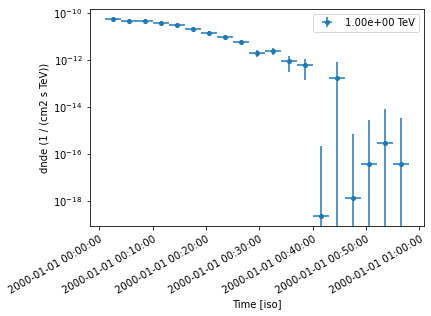

In [15]:
lc_1d.plot(marker="o")

In [68]:
meta

{'MJDREFI': 51544,
 'MJDREFF': 0.0007428703684126958,
 'TIMESYS': 'tt',
 'TIMEUNIT': 's'}

<AxesSubplot:xlabel='Time [iso]', ylabel='Norm / A.U.'>

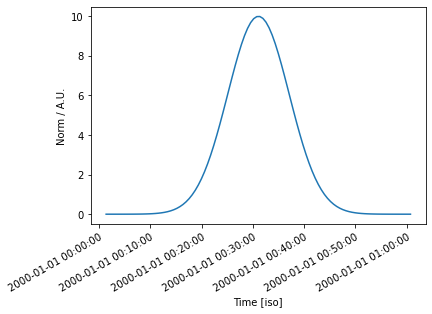

In [69]:
livetime = 1 * u.hr
sigma = 0.1 * u.h
t_ref = Time(51544.00074287037, format="mjd", scale="tt")
times = t_ref.mjd * u.d + livetime * np.linspace(0, 1, 1000)

flare_model = GaussianTemporalModel(t_ref=times[500], sigma=sigma)

# create the astropy table
from gammapy.utils.time import time_ref_to_dict
meta = time_ref_to_dict(t_ref)
lc = Table()
lc.meta = meta
lc.meta["TIMEUNIT"] = 's'

t = Time(times, format="mjd", scale="tt")
lc["TIME"] = (times - times[0]).to("s")
lc["NORM"] = flare_model(t)*10
temporal_model = LightCurveTemplateTemporalModel(lc)
temporal_model.plot([t[0],t[-1]])

In [70]:
temporal_model.table

TIME,NORM
s,
float64,float64
0.0,3.634505310869651e-05
3.60360334161669,3.821041607566253e-05
7.207207311876118,4.016749174454223e-05
10.810810653492808,4.22205745678103e-05
14.414414623752236,4.4374150565757e-05
18.018017965368927,4.663290233415941e-05
21.621621935628355,4.9001720230618364e-05
25.225225277245045,5.148570770603842e-05


<AxesSubplot:xlabel='Time [iso]', ylabel='Norm / A.U.'>

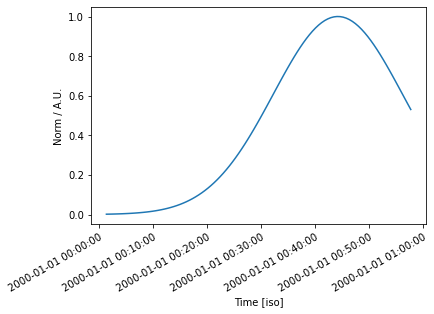

In [19]:
t0 = 0.2 * u.hr
t_ref = Time(51544.00074287037, format="mjd", scale="tt").mjd * u.d
temporal_model = GaussianTemporalModel(t_ref=t_ref, sigma=t0)
temporal_model.plot([times[0],times[-1]])

In [20]:
datasets = Datasets()

for idx, fp in enumerate(lc_1d.iter_by_axis(axis_name="time")):
    dataset = FluxPointsDataset(data=fp, name=f"time-bin-{idx}")
    datasets.append(dataset)

In [21]:
spectral_model1 = PowerLawSpectralModel(
    index=2.0, amplitude="5e-11 cm-2 s-1 TeV-1", reference="1 TeV"
)
spectral_model1.parameters["index"].frozen = True

t_ref = Time(51544.00074287037, format="mjd", scale="tt").mjd * u.d
temporal_model1 = GaussianTemporalModel(t_ref=t_ref, sigma="10 min")

model = SkyModel(
    spectral_model=spectral_model1,
    temporal_model=temporal_model1,
    name="test_source",
)

In [22]:
datasets.models = model

In [23]:
print(datasets.models)

DatasetModels

Component 0: SkyModel

  Name                      : test_source
  Datasets names            : None
  Spectral model type       : PowerLawSpectralModel
  Spatial  model type       : 
  Temporal model type       : GaussianTemporalModel
  Parameters:
    index                 (frozen):      2.000                   
    amplitude                     :   5.00e-11   +/- 0.0e+00 1 / (cm2 s TeV)
    reference             (frozen):      1.000       TeV         
    t_ref                         :  51544.001   +/-    0.00 d           
    sigma                         :     10.000   +/-    0.00 min         




In [24]:
fit = Fit()
result = fit.run(datasets=datasets)
result.optimize_result

OptimizeResult

	backend    : minuit
	method     : migrad
	success    : False
	message    : Optimization terminated successfully.
	nfev       : 167
	total stat : 6.60


In [25]:
result.parameters.to_table()

type,name,value,unit,error,min,max,frozen,is_norm,link
str8,str9,float64,str14,float64,float64,float64,bool,bool,str1
spectral,index,2.0000e+00,,0.000e+00,nan,nan,True,False,
spectral,amplitude,5.0607e-11,cm-2 s-1 TeV-1,1.500e-11,nan,nan,False,True,
spectral,reference,1.0000e+00,TeV,0.000e+00,nan,nan,True,False,
temporal,t_ref,5.1544e+04,d,3.881e-03,nan,nan,False,False,
temporal,sigma,1.1459e+01,min,1.956e-01,nan,nan,False,False,


In [26]:
lc_1d._data["norm_err"].data = lc_1d._data["norm_err"].data/max(lc_1d.norm.data)
lc_1d._data["norm"].data = lc_1d._data["norm"].data/max(lc_1d.norm.data)

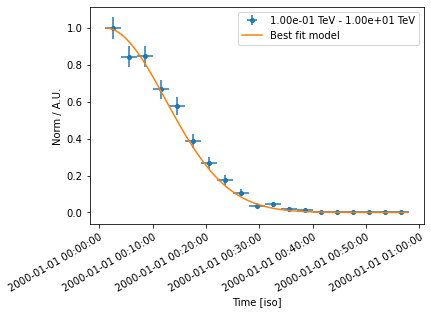

In [27]:
#lc_1TeV_10TeV = lc_1d.slice_by_idx({"energy": slice(2, 3)})
ax = lc_1d.plot(sed_type="norm", axis_name="time")

time_range = lc_1d.geom.axes["time"].time_bounds
temporal_model1.plot(time_range=time_range, label="Best fit model")

ax.set_yscale("linear")
plt.legend()

In [290]:
datasets.models.write?

Signature:
datasets.models.write(
    path,
    overwrite=False,
    full_output=False,
    overwrite_templates=False,
    write_covariance=True,
)
Docstring:
Write to YAML file.

Parameters
----------
path : `pathlib.Path` or str
    path to write files
overwrite : bool
    overwrite YAML files
full_output : bool
    Store full parameter output.
overwrite_templates : bool
    overwrite templates FITS files
write_covariance : bool
    save covariance or not
File:      ~/opt/anaconda3/envs/gammapy-0.20.1/lib/python3.8/site-packages/gammapy/modeling/models/core.py
Type:      method


In [48]:
circle = CircleSkyRegion(center=target_position, radius=0.2 * u.deg)
exclusion_mask = WCS_GEOM.region_mask([circle], inside=False)

In [52]:
fov_bkg_maker = FoVBackgroundMaker(method="fit", exclusion_mask=exclusion_mask)

dataset_new = fov_bkg_maker.run(dataset)
dataset.stack(dataset_new)

ValueError: Map Arithmetic: Inconsistent geometries.

In [42]:
dataset_on_off = bkg_maker.run(dataset, observation)

ValueError: Map Arithmetic: Inconsistent geometries.

In [19]:
target_position = SkyCoord(0.0, 0.0, frame="galactic", unit="deg")
on_region_radius = Angle("0.11 deg")
on_region = CircleSkyRegion(center=target_position, radius=on_region_radius)

geom = RegionGeom.create(region=on_region, axes=[ENERGY_AXIS])

In [23]:
dataset_maker = SpectrumDatasetMaker(
    containment_correction=True, selection=["counts", "exposure", "edisp"]
)
bkg_maker = FoVBackgroundMaker()

In [36]:
%%time
observation.events = events

datasets = Datasets()

dataset_empty = SpectrumDataset.create(
    geom=geom, energy_axis_true=ENERGY_AXIS_TRUE
)

dataset = dataset_maker.run(dataset_empty.copy(), observation)
dataset_on_off = bkg_maker.run(dataset, observation)
datasets.append(dataset_on_off)

TypeError: FoVBackgroundMaker does not support region based datasets.

In [9]:
spectral_model = PowerLawSpectralModel(
    index=2, amplitude="1e-12 cm-2 s-1 TeV-1", reference="1 TeV"
)
model_fit = SkyModel(spectral_model=spectral_model, name="model-fit")

In [11]:
dataset.models = model_fit

In [14]:
from gammapy.estimators import LightCurveEstimator

lc_maker_1d = LightCurveEstimator(
    energy_edges=[0.1, 0.3, 0.6, 1.0, 5, 10] * u.TeV,
    source="model-fit",
    selection_optional=["ul"],
)
lc_1d = lc_maker_1d.run(dataset)

ValueError: cannot reshape array of size 80 into shape (80,400,400)